# **CS598 Deep Learning for Healthcare**

## **1. Setup**

### 1.1 Change the google colab settings
We can use a GPU on the google colab by setting below.  
**Edit -> Notebook setting -> Hardware accelerator -> GPU**

### 1.2 Check if the GPU is available in the Colab environment

In [ ]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()
print('Device name: {}'.format(device_name))

Device name: /device:GPU:0


### 1.3 GPU setting for PyTourch

In [ ]:
# The code in this cell is inspired by https://mccormickml.com/2019/07/22/BERT-fine-tuning/
import torch

# Tell PyTorch to use the GPU
device = torch.device("cuda")
print('GPU:', torch.cuda.get_device_name(0))

GPU: Tesla T4


### 1.4 Install necessary packages


In [ ]:
# if needed

## **2. Dataset loading**

### 2.1 Load the IQVIA data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[Note]
Need to upload the iqvia data to your google drive

In [ ]:
DATA_DIR = '/content/drive/MyDrive/iqvia_data/'

In [ ]:
import pandas as pd
ENROLL_FILE = DATA_DIR + 'enroll_synth.dat'
CLAIMS_2019 = DATA_DIR + 'claims_2019.dat'
CLAIMS_2018 = DATA_DIR + 'claims_2018.dat'
CLAIMS_2017 = DATA_DIR + 'claims_2017.dat'
CLAIMS_2016 = DATA_DIR + 'claims_2016.dat'
CLAIMS_2015 = DATA_DIR + 'claims_2015.dat'

df_enroll = pd.read_csv(ENROLL_FILE, sep='|', low_memory=False)

df_claims2019 = pd.read_csv(CLAIMS_2019, sep='|', low_memory=False)
df_claims2018 = pd.read_csv(CLAIMS_2018, sep='|', low_memory=False)
df_claims2017 = pd.read_csv(CLAIMS_2017, sep='|', low_memory=False)
df_claims2016 = pd.read_csv(CLAIMS_2016, sep='|', low_memory=False)
df_claims2015 = pd.read_csv(CLAIMS_2015, sep='|', low_memory=False)

## Add year and create a single dataset for claims
df_claims2015["year"] = 2015
df_claims2016["year"] = 2016
df_claims2017["year"] = 2017
df_claims2018["year"] = 2018
df_claims2019["year"] = 2019

list_of_claims = [df_claims2015, df_claims2016, df_claims2017, df_claims2018, df_claims2019]
df_claims = pd.concat(list_of_claims)

In [ ]:
# enroll data
print("Shape of Claims{}".format(df_enroll.shape))
df_enroll.sample(n=5, random_state=0)

Shape of Claims(30000, 17)


,estring,clm_frst,clm_last,nbr_clm_lines,enr_frst,enr_last,mon_totl,mxce_fst,mxce_lst,der_sex,der_yob,pat_id,pat_region,pat_state,grp_indv_cd,mh_cd,enr_rel
8225,----------------------------------------------...,2006-01-10,2017-12-27,417,2006-01-01,2018-03-31,147,2006-01-01,2018-03-31,F,1943.0,f433AAAAAAAGVWTS,E,NY,U,Y,21
10794,----------------------------------------------...,2006-06-07,2018-03-05,140,2006-01-01,2018-03-31,147,2006-01-01,2018-03-31,M,1964.0,f433AAAAAAAHRYHG,E,NY,U,Y,21
9163,----------------------------------------------...,2007-07-23,2017-03-14,345,2006-01-01,2017-03-31,135,2006-01-01,2017-03-31,F,1960.0,k306AAAAAABKDKXE,NaN,NaN,U,Y,21
26591,----------------------------------------------...,2016-01-01,2016-03-11,28,2016-01-01,2016-12-31,12,2016-01-01,2016-12-31,M,2015.0,a7e3AAAAAAPPAPTW,W,CA,U,N,21
6631,----------------------------------------------...,2017-04-28,2017-05-26,22,2016-03-01,2017-05-31,15,2016-03-01,2017-05-31,F,1995.0,pg20AAAAADXVWYQN,MW,IL,U,N,21


In [ ]:
# claim data
print("Shape of Claims{}".format(df_claims.shape))
df_claims.sample(n=5, random_state=0)

Shape of Claims(2438054, 65)


,pat_id,claimno,linenum,rectype,tos_flag,pos,conf_num,patstat,billtype,ndc,daw,formulary,dayssup,quan,proc_cde,cpt_mod,rev_code,srv_unit,from_dt,to_dt,diagprc_ind,diag_admit,diag1,diag2,diag3,diag4,diag5,diag6,diag7,diag8,diag9,diag10,diag11,diag12,icdprc1,icdprc2,icdprc3,icdprc4,icdprc5,icdprc6,icdprc7,icdprc8,icdprc9,icdprc10,icdprc11,icdprc12,charge,allowed,paid,deductible,copay,coinsamt,cobamt,dispense_fee,bill_spec,rend_spec,prscbr_spec,att_spec,pcp_spec,ref_spec,ptypeflg,sub_tp_cd,pmt_st_cd,paid_dt,year
436407,pf06AAAAAAANBFBA,NaN,1.0,P,0,01,NaN,NaN,NaN,3.78181e+08,NaN,NaN,30.0,15.0,NaN,NaN,NaN,NaN,2015-07-17,2015-07-17,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.22,8.22,6.90,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,U,P,2015-07-22,2015
102630,a7c7AAAAAAMVLNUZ,BM00016399762,1.0,M,1,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99283,NaN,NaN,1.0,2016-10-17,2016-10-17,2,NaN,M79672,M79675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,970.00,970.00,44.60,NaN,NaN,0.0,0.0,NaN,OTHER,OTHER,NaN,NaN,NaN,NaN,0,U,P,2016-11-16,2016
552992,pg03AAAAAAQCOAHC,NaN,1.0,A,0,13,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250,NaN,2015-05-16,2015-05-16,1,NaN,4659,6869,6929,7862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.70,0.00,0.00,NaN,NaN,0.0,0.0,NaN,HOSPITAL,HOSPITAL,NaN,NaN,NaN,NaN,1,U,P,2015-06-15,2015
141699,9004AAAAAAAIWZJJ,1.93473e+11,1.0,M,1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99212,NaN,NaN,1.0,2019-11-06,2019-11-06,2,NaN,M47812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.00,112.20,102.20,0.0,10.0,0.0,0.0,NaN,OTHR_SPC,OTHR_SPC,NaN,NaN,NaN,NaN,0,U,P,2019-12-06,2019
355175,pg03AAAAAABZBLAE,NaN,4.0,M,1,13,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450,NaN,2015-11-02,2015-11-02,2,NaN,R55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3027.00,52.91,52.91,NaN,NaN,0.0,0.0,NaN,HOSPITAL,HOSPITAL,NaN,NaN,NaN,NaN,1,U,P,2015-12-02,2015


### 2.2 Analyze the dataset

22138
926


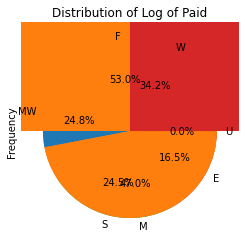

30000
18927
21483
15190
6445
4884


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Distribution of patients across regions
rd = df_enroll["pat_region"].value_counts().plot(kind="pie", autopct="%1.1f%%")
rd.set_title("Distribution of patients across regions")

# Distribution of patients gender
rd = df_enroll["der_sex"].value_counts().plot(kind="pie", autopct="%1.1f%%")
rd.set_title("Distribution of patients' gender")

# Distribution of Age
df_enroll["age"] = 2021 - df_enroll["der_yob"]

rd = df_enroll[df_enroll["der_yob"] > 1900]["age"].plot(kind='hist', bins=15)
rd.set_title("Distribution of patients' age")

# Get the count of claims paid (and denied)
df_claims["pmt_st_cd"].value_counts()

# number of diagnosis populated in each claim
diag_cols = ["diag1", "diag2", "diag3", "diag4", "diag5", "diag6", "diag7", "diag8", "diag9", "diag10", "diag11", "diag12"]
df_claims["num_of_diag"] = df_claims[diag_cols].notnull().sum(axis=1)
df_claims["num_of_diag"].mean()

# number of icdprc populated in each claim
icdprc_cols=["icdprc1", "icdprc2", "icdprc3", "icdprc4", "icdprc5", "icdprc6", "icdprc7", "icdprc8", "icdprc9", "icdprc10", "icdprc11", "icdprc12"]
df_claims["num_of_icdprc"] = df_claims[icdprc_cols].notnull().sum(axis=1)
df_claims["num_of_icdprc"].mean()

diag = []
for colname in diag_cols:
    diag.extend(pd.unique(df_claims[colname]))
print(len(np.unique(diag)))
# 22138

prc = []
for colname in icdprc_cols:
    prc.extend(pd.unique(df_claims[colname]))
print(len(np.unique(prc)))
# 926


# number of claims with same day service
sum(df_claims["from_dt"] == df_claims["to_dt"])
# 2378556 out of 2438054 i.e. 97.5%

# Distribution of charges
rd = df_claims["charge"].plot(kind='hist', bins=15)
rd.set_title("Distribution charges")

# Log charges makes more sense
# filtering out rows where charges are less than 1
rd = np.log10(df_claims[df_claims["charge"] > 1]["charge"]).plot(kind='hist', bins=15)
rd.set_title("Distribution of Log of Charges")

# Distribution of Paid amounts
# filtering out rows where paid are less than 1
rd = np.log10(df_claims[df_claims["paid"] > 1]["paid"]).plot(kind='hist', bins=25)
rd.set_title("Distribution of Log of Paid")
plt.show()


# Checking the unique number of patients in the datasets
print(len(pd.unique(df_enroll['pat_id'])))
# 30000
print(len(pd.unique(df_claims2015['pat_id'])))
# 18927
print(len(pd.unique(df_claims2016['pat_id'])))
#21483
print(len(pd.unique(df_claims2017['pat_id'])))
#15190
print(len(pd.unique(df_claims2018['pat_id'])))
#6445
print(len(pd.unique(df_claims2019['pat_id'])))
#4884

## **3. Data embedding**

### 3.1 Embedding

In [ ]:
# each patient with a single record
# x -> aggregation of rows from all except last qtr
# y -> charged in last qtr

# 1. first assign quarter to each record
df_claims["quarter"] = pd.PeriodIndex(pd.to_datetime(df_claims["to_dt"]), freq = 'Q')

# 2. find the latest quarter for each patient
df_patient_last_quarter = df_claims.groupby('pat_id')["quarter"].max().reset_index()

# 3. Find claims for patient in last quarter and not in last quarter

df_claims_last_quarter = df_claims[df_claims.set_index(['pat_id','quarter']).index.isin(df_patient_last_quarter.set_index(['pat_id','quarter']).index)]
df_claims_not_last_quarter = df_claims[~df_claims.set_index(['pat_id','quarter']).index.isin(df_patient_last_quarter.set_index(['pat_id','quarter']).index)]

# 4. confirm many unique patients are in both sets
len(pd.unique(df_claims_last_quarter['pat_id']))
# 27226
sum(np.isin(pd.unique(df_claims_not_last_quarter["pat_id"]), pd.unique(df_claims_last_quarter["pat_id"])))
# 24970

# Create y variable for each patient
df_y = df_claims_last_quarter.groupby('pat_id')["charge"].sum().reset_index()

# Create x variable for each patient??

### 3.2 Dataloader

In [ ]:
# Create dataloader

## **4. Model building**

### **4.1 Random Forest**

In [ ]:
# Bala, Kautuk

### **4.2 Base model(Drewe-Boss’s paper)**

In [ ]:
# The purpose of this model is to reproduce the prior model proposed by Drewe-Boss et al.  Deep learning for prediction of population health costs

# This code is inspired by 
#  (1) https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/UEdCb/homework-2-neural-networks/lab
#  (2) https://www.coursera.org/learn/cs598-deep-learning-for-healthcare/programming/VNfPA/homework-4-mina/lab

import torch
import torch.nn as nn
import torch.nn.functional as F

class Basemodel(nn.Module):
    def __init__(self, input_size=1000, output_size=1): # default input size is a tentative value, need to be specified with embedding vector size
        super(Basemodel, self).__init__()
        self.input_size = input_size
        self.hidden_size = 50
        self.output_size = output_size

        self.fc1 = torch.nn.Linear(in_features=self.input_size, out_features=self.hidden_size)
        self.fc2 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.fc3 = torch.nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.fc4 = torch.nn.Linear(in_features=self.hidden_size+self.input_size, out_features=self.output_size)
        self.do = nn.Dropout(0.25)

    def forward(self, x):
        x0 = x # x0 will be override?
        x = self.do(F.relu(self.fc1(x)))
        x = self.do(F.relu(self.fc2(x)))
        x = self.do(F.relu(self.fc3(x)))
        x = torch.cat((x, x0), dim=0) # need to debug with actual data
        x = self.do(F.relu(self.fc4(x)))
        
        return x

model = Basemodel() # Need to specify the input/output size(we have not decided input and output data)
print(model)

Basemodel(
  (fc1): Linear(in_features=1000, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=1050, out_features=1, bias=True)
  (do): Dropout(p=0.25, inplace=False)
)


### **4.3 Advanced model(Base model + alpha)**

In [ ]:
# Idea